<a href="https://colab.research.google.com/github/siren7075/hackathon2024/blob/main/thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Process 3 mo Exchange Rates Data: Get Anomalies for SPOT currency rates: sort by date and group by currency , then get percentile changes and their thresholds, export as exchange_rates_thresholds.csv**


In [ ]:
import pandas as pd
from scipy import stats

# Load the CSV data
df = pd.read_csv('fx_rates_spot_forward_MID_3mo_fromUSD.csv')

# Filter the DataFrame for fxType "SPOT"
spot_df = df[df['fxType'] == 'SPOT']

# Group by currency and sort by effectiveDate
spot_df = spot_df.sort_values(by=['toCurrencyCode', 'effectiveDate'])

# Prepare a DataFrame to store anomalies and thresholds
anomalies = pd.DataFrame()

# Calculate percentage changes and thresholds for each currency group
for currency, group in spot_df.groupby('toCurrencyCode'):
    group['percentage_change'] = group['spotRate'].pct_change() * 100

    # Calculate mean and standard deviation of percentage changes
    mean_change = group['percentage_change'].mean()
    std_dev_change = group['percentage_change'].std()

    # Define thresholds using Z-score method
    k = 2  # Adjust k for strictness
    lower_threshold = mean_change - k * std_dev_change
    upper_threshold = mean_change + k * std_dev_change

    # Identify anomalies based on the thresholds
    group['is_anomaly'] = ((group['percentage_change'] < lower_threshold) |
                           (group['percentage_change'] > upper_threshold))

    # Store the thresholds in the group DataFrame
    group['lower_threshold'] = lower_threshold
    group['upper_threshold'] = upper_threshold

    # Append anomalies to the anomalies DataFrame
    anomalies = pd.concat([anomalies, group])

# Append the new columns to the original DataFrame
spot_df['is_anomaly'] = anomalies['is_anomaly']
spot_df['lower_threshold'] = anomalies['lower_threshold']
spot_df['upper_threshold'] = anomalies['upper_threshold']
spot_df['percentage_change'] = anomalies['percentage_change']

print(spot_df)

# Append the anomalies DataFrame to the original CSV
anomalies.to_csv('exchange_rates_thresholds.csv', mode='a', header=True, index=False)

      effectiveDate fxType snapCode rateType fromCurrencyCode toCurrencyCode  \
433      2024-09-11   SPOT   LN1500      MID              USD            AED   
869      2024-09-12   SPOT   LN1500      MID              USD            AED   
1258     2024-09-13   SPOT   LN1500      MID              USD            AED   
1739     2024-09-16   SPOT   LN1500      MID              USD            AED   
2127     2024-09-17   SPOT   LN1500      MID              USD            AED   
...             ...    ...      ...      ...              ...            ...   
26934    2024-12-05   SPOT   LN1500      MID              USD            KRW   
27333    2024-12-06   SPOT   LN1500      MID              USD            KRW   
27804    2024-12-09   SPOT   LN1500      MID              USD            KRW   
28203    2024-12-10   SPOT   LN1500      MID              USD            KRW   
28638    2024-12-11   SPOT   LN1500      MID              USD            KRW   

       forwardRate  forwardPeriodCode  




**2. Append Exchange Rate Anomalies Data to this hedge table, also calculate SOD EOD Hedge Data**

Group by 'grouphedgeid' and 'currrency'.

In [ ]:
import pandas as pd

# Load the data (assuming it's already been loaded as 'final_data')
final_data = pd.read_csv('latest_combined_hedges.csv')

# Ensure the relevant columns are in the correct format
final_data['sodhedgeusd'] = final_data['sodhedgeusd'].astype(float)
final_data['eoddhedgeusd'] = final_data['eoddhedgeusd'].astype(float)
final_data['spotrate'] = final_data['spotrate'].astype(float)

# Initialize an empty DataFrame to store anomalies
anomalies = pd.DataFrame()

# Group by 'grouphedgeid' and 'currrency'
for (grouphedgeid, currency), group in final_data.groupby(['grouphedgeid', 'currrency']):
    # Calculate the percentage change of the spotrate
    group['percentage_change'] = group['spotrate'].pct_change(fill_method=None) * 100

    # Calculate mean and standard deviation of percentage changes
    mean_change = group['percentage_change'].mean()
    std_dev_change = group['percentage_change'].std()

    # Define thresholds using Z-score method
    k = 2  # Adjust k for strictness
    lower_threshold = mean_change - k * std_dev_change
    upper_threshold = mean_change + k * std_dev_change

    # Identify anomalies based on the thresholds
    group['is_rate_anomaly'] = ((group['percentage_change'] < lower_threshold) |
                           (group['percentage_change'] > upper_threshold))

    # Store the thresholds in the group DataFrame
    group['lower_threshold'] = lower_threshold
    group['upper_threshold'] = upper_threshold

    # Calculate EOD-SOD Difference
    group['EOD_SOD_diff'] = (group['sodhedgeusd'] - group['eoddhedgeusd'].shift(1)) / group['eoddhedgeusd'].shift(1)

    # Create flags based on the EOD-SOD difference
    group['EOD_SOD_flag'] = ((group['EOD_SOD_diff'] > group['mishedgehighthreasold']) |
                             (group['EOD_SOD_diff'] < group['mishedgelowthreasold']))

    # Append anomalies to the anomalies DataFrame
    anomalies = pd.concat([anomalies, group], ignore_index=True)

print(anomalies)

anomalies.to_csv('final_data_with_anomalies_and_flags.csv', index=False)

       TradingDayDate   sodhedgeusd  eoddhedgeusd  grouphedgeid currrency  \
0          2024-06-13 -9.171786e+05 -2.110794e+05             3       EUR   
1          2024-06-14  2.290725e+06  6.949030e+04             3       EUR   
2          2024-06-17  0.000000e+00  0.000000e+00             3       EUR   
3          2024-06-18  0.000000e+00  0.000000e+00             3       EUR   
4          2024-06-19  0.000000e+00  0.000000e+00             3       EUR   
...               ...           ...           ...           ...       ...   
326745     2024-12-05 -1.111200e+07 -5.502216e+06          1091       USD   
326746     2024-12-06 -2.279258e+07  4.010577e+08          1091       USD   
326747     2024-12-09 -1.256161e+06 -1.105035e+07          1091       USD   
326748     2024-12-10 -1.096819e+07 -1.096819e+07          1091       USD   
326749     2024-12-11 -1.094016e+07 -1.273083e+07          1091       USD   

        spotrate                       ratedate  mishedgelowthreasold  \
0 

In [ ]:
print(anomalies)

       TradingDayDate   sodhedgeusd  eoddhedgeusd  grouphedgeid currrency  \
0          2024-06-13 -9.171786e+05 -2.110794e+05             3       EUR   
1          2024-06-14  2.290725e+06  6.949030e+04             3       EUR   
2          2024-06-17  0.000000e+00  0.000000e+00             3       EUR   
3          2024-06-18  0.000000e+00  0.000000e+00             3       EUR   
4          2024-06-19  0.000000e+00  0.000000e+00             3       EUR   
...               ...           ...           ...           ...       ...   
326745     2024-12-05 -1.111200e+07 -5.502216e+06          1091       USD   
326746     2024-12-06 -2.279258e+07  4.010577e+08          1091       USD   
326747     2024-12-09 -1.256161e+06 -1.105035e+07          1091       USD   
326748     2024-12-10 -1.096819e+07 -1.096819e+07          1091       USD   
326749     2024-12-11 -1.094016e+07 -1.273083e+07          1091       USD   

        spotrate                       ratedate  mishedgelowthreasold  \
0 

**3. Plotting Anomaly Counts**

<ipython-input-55-98840ac73f94>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=anomaly_counts, x='Currency', y='Anomaly Count', palette='viridis')


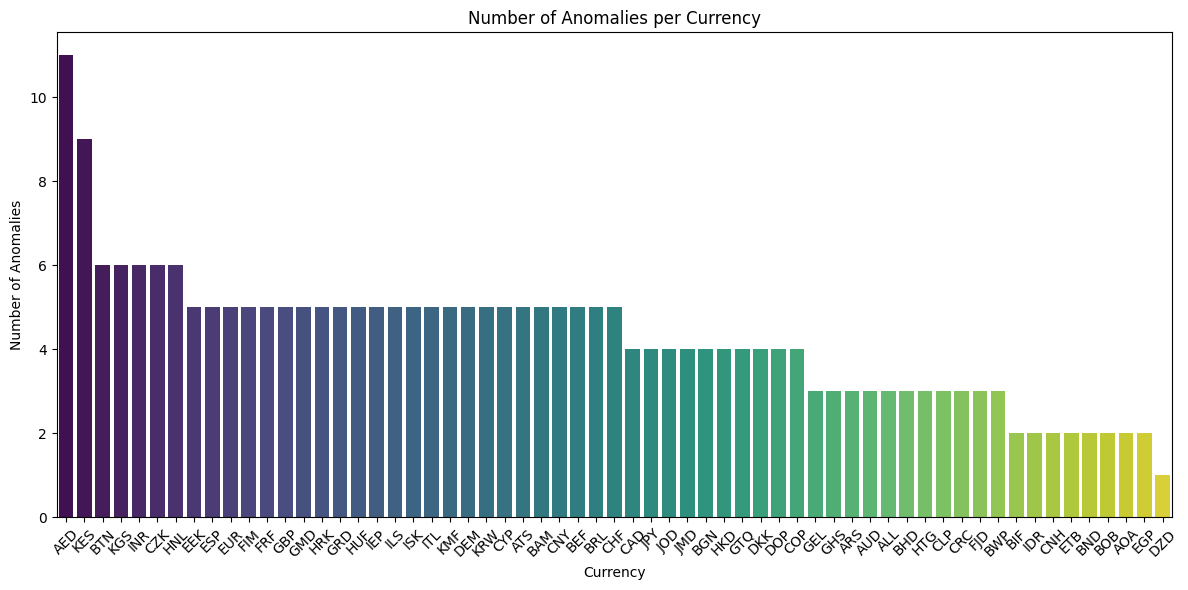

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

anomalies_only = spot_df[spot_df['is_anomaly'] == True]

# Create a count of anomalies per currency
anomaly_counts = anomalies_only['toCurrencyCode'].value_counts().reset_index()
anomaly_counts.columns = ['Currency', 'Anomaly Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=anomaly_counts, x='Currency', y='Anomaly Count', palette='viridis')
plt.title('Number of Anomalies per Currency')
plt.xlabel('Currency')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**4.Trends of the TOP 5 Currencies with Most Anomalies**

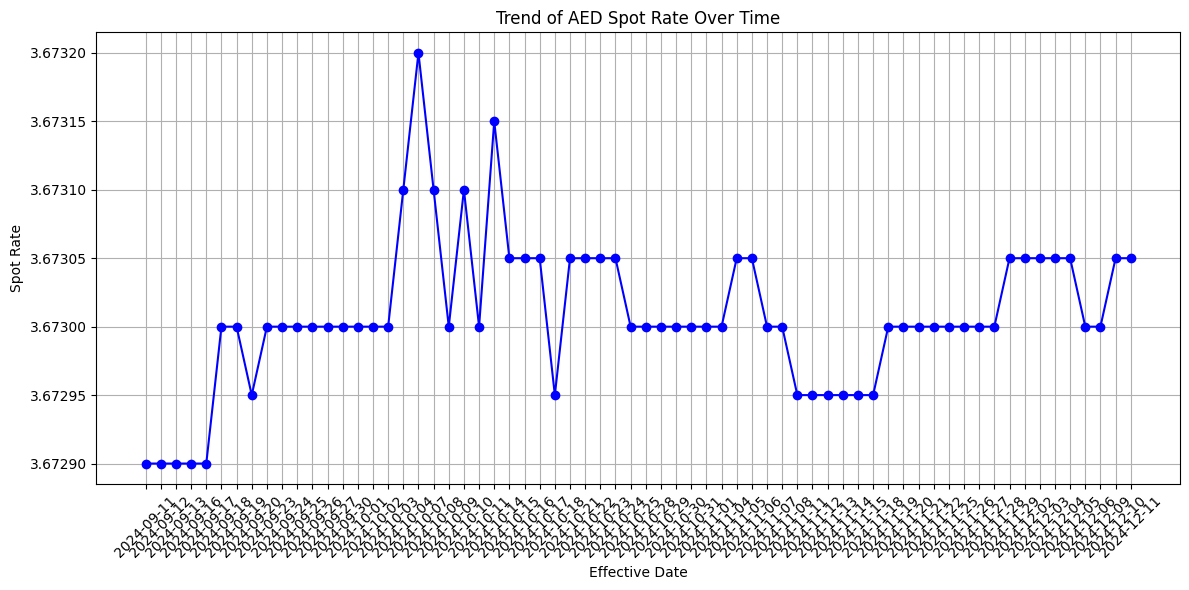

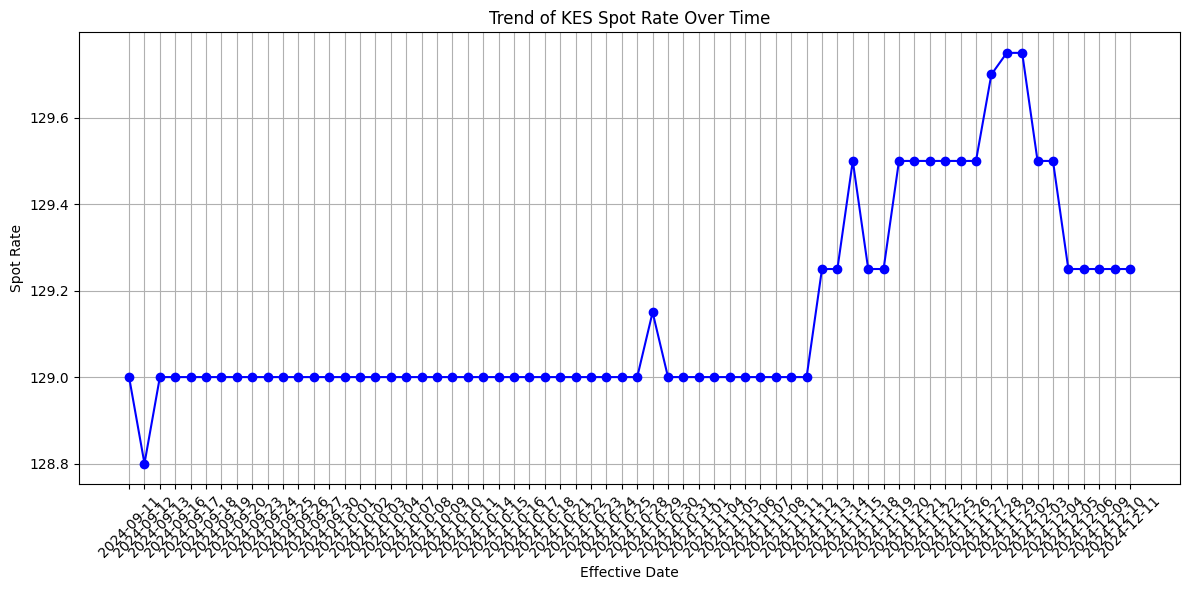

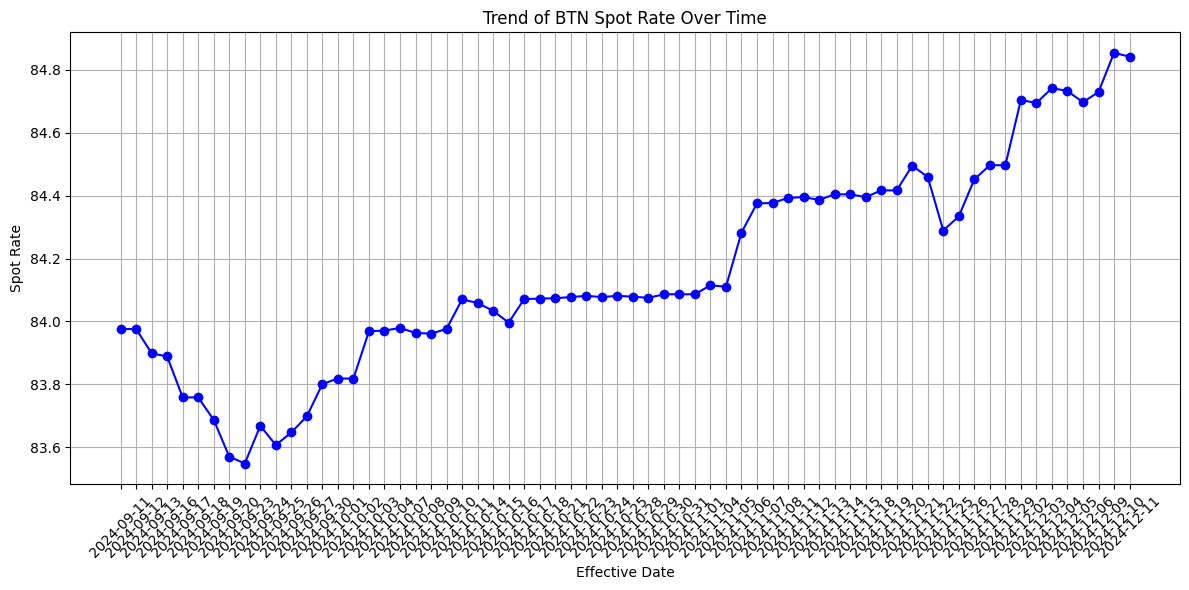

In [ ]:
# Extract the top 3 currencies with the most anomalies
top_anomaly_currencies = (anomalies_only['toCurrencyCode']
                          .value_counts()
                          .head(3)
                          .index
                          .tolist())

# Create separate plots for each of the top anomaly currencies
for currency in top_anomaly_currencies:
    currency_data = spot_df[spot_df['toCurrencyCode'] == currency]

    plt.figure(figsize=(12, 6))
    plt.plot(currency_data['effectiveDate'], currency_data['spotRate'], marker='o', linestyle='-', color='b')
    plt.title(f'Trend of {currency} Spot Rate Over Time')
    plt.xlabel('Effective Date')
    plt.ylabel('Spot Rate')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

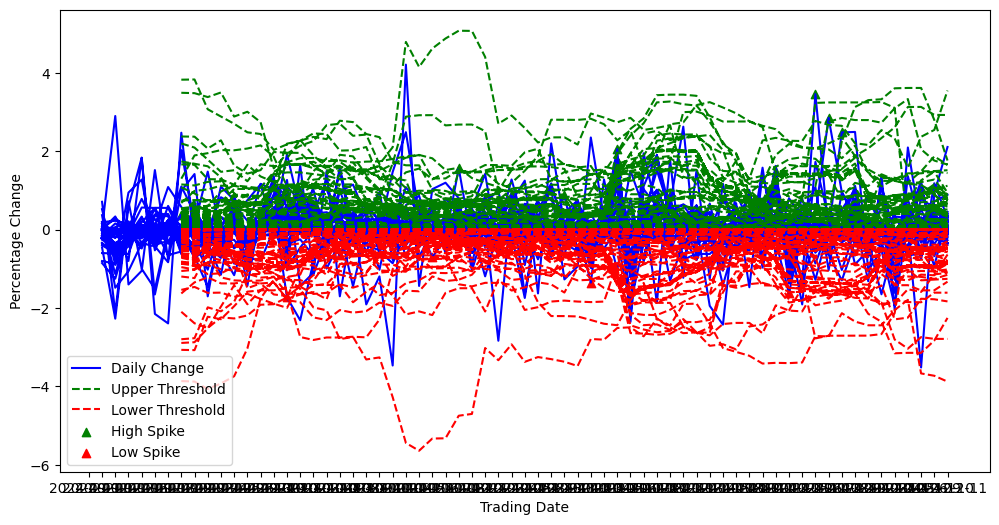

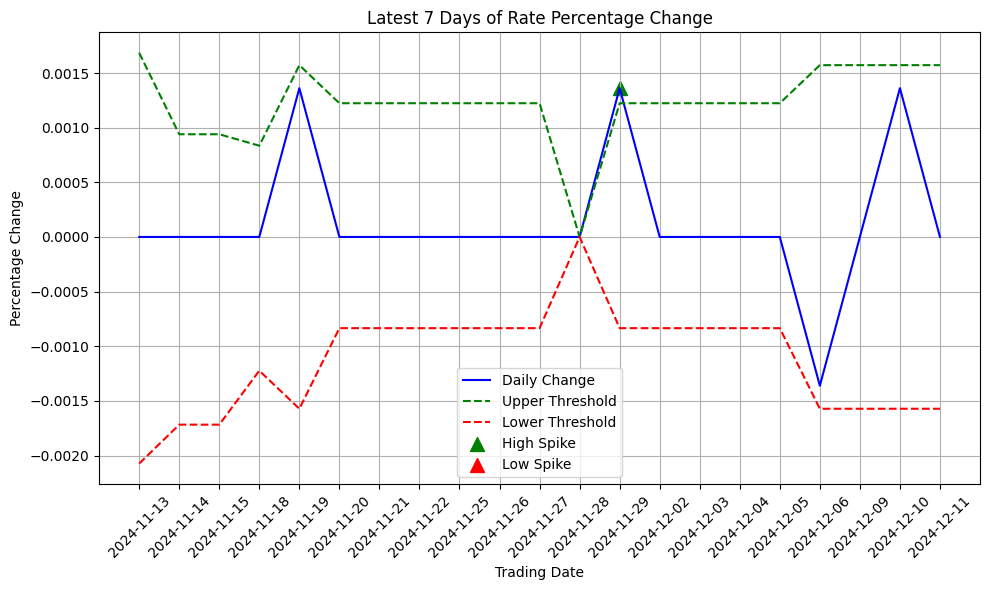

      effectiveDate toCurrencyCode  spotRate    change  HighSpike  LowSpike  \
19946    2024-11-13            AED   3.67295  0.000000      False     False   
20404    2024-11-14            AED   3.67295  0.000000      False     False   
20873    2024-11-15            AED   3.67295  0.000000      False     False   
21312    2024-11-18            AED   3.67295  0.000000      False     False   
21747    2024-11-19            AED   3.67300  0.001361      False     False   
22146    2024-11-20            AED   3.67300  0.000000      False     False   
22611    2024-11-21            AED   3.67300  0.000000      False     False   
23020    2024-11-22            AED   3.67300  0.000000      False     False   
23487    2024-11-25            AED   3.67300  0.000000      False     False   
23921    2024-11-26            AED   3.67300  0.000000      False     False   
24357    2024-11-27            AED   3.67300  0.000000      False     False   
24770    2024-11-28            AED   3.67300  0.0000

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV data
df = pd.read_csv('fx_rates_spot_forward_MID_3mo_fromUSD.csv')

# sort by currency & effectiveDate
df = df.sort_values(by=['toCurrencyCode', 'effectiveDate'])
df = df[df['fxType'] == 'SPOT']
# Calculate percentage change using the original DataFrame 'df'
df['change'] = df.groupby('toCurrencyCode')['spotRate'].pct_change() * 100

# Rolling statistics (7 days window)
rolling_window = 7
df['RollingMean'] = df.groupby('toCurrencyCode')['change'].transform(lambda x: x.rolling(rolling_window).mean())
df['RollingStd'] = df.groupby('toCurrencyCode')['change'].transform(lambda x: x.rolling(rolling_window).std())

# Assuming 'k' is defined somewhere before this code, if not, please define it
k = 2
df['UpperThreshold'] = df['RollingMean'] + k * df['RollingStd']
df['LowerThreshold'] = df['RollingMean'] - k * df['RollingStd']

df['HighSpike'] = df['change'] > df['UpperThreshold']
df['LowSpike'] = df['change'] < df['LowerThreshold']

# plot
plt.figure(figsize=(12, 6))
plt.plot(df['effectiveDate'], df['change'], label='Daily Change', color='blue')
plt.plot(df['effectiveDate'], df['UpperThreshold'], label='Upper Threshold', color='green', linestyle='--')
plt.plot(df['effectiveDate'], df['LowerThreshold'], label='Lower Threshold', color='red', linestyle='--')

plt.scatter(df['effectiveDate'][df['HighSpike']], df['change'][df['HighSpike']], color='green', label='High Spike', marker='^')
plt.scatter(df['effectiveDate'][df['LowSpike']], df['change'][df['LowSpike']], color='red', label='Low Spike', marker='^')

plt.legend()

plt.xlabel('Trading Date')
plt.ylabel('Percentage Change')

plt.show()

currency_data = df[df['toCurrencyCode'] == 'AED']
latest_7_days = currency_data.tail(21)
plt.figure(figsize=(10, 6))
plt.plot(latest_7_days['effectiveDate'], latest_7_days['change'], label='Daily Change', color='blue')
plt.plot(latest_7_days['effectiveDate'], latest_7_days['UpperThreshold'], label='Upper Threshold', color='green', linestyle='--')
plt.plot(latest_7_days['effectiveDate'], latest_7_days['LowerThreshold'], label='Lower Threshold', color='red', linestyle='--')

plt.scatter(latest_7_days['effectiveDate'][latest_7_days['HighSpike']], latest_7_days['change'][latest_7_days['HighSpike']], color='green', label='High Spike', marker='^', s=100)
plt.scatter(latest_7_days['effectiveDate'][latest_7_days['LowSpike']], latest_7_days['change'][latest_7_days['LowSpike']], color='red', label='Low Spike', marker='^', s=100)
plt.legend()

plt.xlabel('Trading Date')
plt.ylabel('Percentage Change')
plt.title('Latest 7 Days of Rate Percentage Change')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

spikes = df[(df['HighSpike'] | df['LowSpike'])]

spikesLimited = spikes[['effectiveDate','toCurrencyCode','spotRate', 'change', 'HighSpike', 'LowSpike', 'UpperThreshold', 'LowerThreshold']]

print(latest_7_days[['effectiveDate','toCurrencyCode','spotRate', 'change', 'HighSpike', 'LowSpike', 'UpperThreshold', 'LowerThreshold']])

print(spikesLimited)